In [ ]:
# Install required libraries
!pip install python-docx
!wget -O Garamond.ttf https://github.com/georgd/EB-Garamond

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 14.6 MB/s eta 0:00:00
--2025-03-30 10:14:35--  https://github.com/google/fonts/raw/main/ofl/ebgaramond/EBGaramond-Regular.ttf
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-03-30 10:14:35 ERROR 404: Not Found.



In [ ]:
from docx import Document
doc = Document("/content/text.docx")
text_pages = [para.text for para in doc.paragraphs if para.text.strip()][:5]
print("Text pages loaded:", len(text_pages))

Text pages loaded: 5


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw, ImageFont
import textwrap
import cv2
import numpy as np
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim

# Setup device and directories
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
os.makedirs("dataset/clean", exist_ok=True)
os.makedirs("dataset/degraded", exist_ok=True)
os.makedirs("output", exist_ok=True)

Using device: cuda


In [ ]:
def create_clean_image(text, page_num):
    """Render clean Renaissance-style text image."""
    font = ImageFont.truetype("/content/EBGaramond08-Italic.ttf", 20)  # Adjust size if needed
    img = Image.new("L", (512, 512), 255)  # Grayscale, white background
    draw = ImageDraw.Draw(img)
    wrapped = textwrap.fill(text, width=40)  # Wrap to fit 512px
    draw.text((10, 10), wrapped, font=font, fill=0)  # Black text
    img.save(f"dataset/clean/page_{page_num}.png")
    return np.array(img)

def create_degraded_image(clean_img, page_num, variation=0):
    """Augment clean image with imperfections."""
    img = clean_img.copy()
    # Ink bleed
    blur_size = (5 + 2 * (variation % 3), 5 + 2 * (variation % 3))  # Ensure odd values
    blurred = cv2.GaussianBlur(img, blur_size, 1.5)
    # Smudging
    smear = cv2.warpAffine(blurred, np.float32([[1, 0.1 * (variation % 2 + 1), 0], [0, 1, 0]]), (512, 512))
    # Fading
    fade_alpha = 0.9 - 0.1 * (variation % 4)  # Vary fading
    faded = cv2.addWeighted(smear, fade_alpha, np.zeros_like(smear), 1 - fade_alpha, 0)
    # Noise
    noise_scale = 15 + 5 * (variation % 3)  # Vary noise
    noise = np.random.normal(0, noise_scale, faded.shape).astype(np.uint8)
    degraded = cv2.add(faded, noise)
    filename = f"dataset/degraded/page_{page_num}_var_{variation}.png" if variation else f"dataset/degraded/page_{page_num}.png"
    cv2.imwrite(filename, degraded)
    return degraded

def prepare_dataset(text_pages):
    """Prepare full dataset with 100 pairs."""
    for i, text in enumerate(text_pages, 1):
        clean_img = create_clean_image(text, i)
        # Generate 20 variations per page (5 pages x 20 = 100 pairs)
        for var in range(20):
            degraded_img = create_degraded_image(clean_img, i, var)
            if var > 0:  # Save clean image for each variation
                cv2.imwrite(f"dataset/clean/page_{i}_var_{var}.png", clean_img)
    print("Dataset prepared: 100 clean-degraded pairs")

prepare_dataset(text_pages)

Dataset prepared: 100 clean-degraded pairs


In [ ]:
class TextDataset(Dataset):
    def __init__(self, clean_dir, degraded_dir):
        self.clean_images = sorted([os.path.join(clean_dir, f) for f in os.listdir(clean_dir)])
        self.degraded_images = sorted([os.path.join(degraded_dir, f) for f in os.listdir(degraded_dir)])
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # Grayscale normalization
        ])

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean_img = Image.open(self.clean_images[idx]).convert("L")
        degraded_img = Image.open(self.degraded_images[idx]).convert("L")
        return self.transform(clean_img), self.transform(degraded_img)

dataset = TextDataset("dataset/clean", "dataset/degraded")
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
print(f"Dataset size: {len(dataset)} pairs")

Dataset size: 100 pairs


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # U-Net encoder
        self.enc1 = nn.Conv2d(1, 64, 4, 2, 1)  # 512 -> 256
        self.enc2 = nn.Conv2d(64, 128, 4, 2, 1)  # 256 -> 128
        self.enc3 = nn.Conv2d(128, 256, 4, 2, 1)  # 128 -> 64
        self.enc4 = nn.Conv2d(256, 512, 4, 2, 1)  # 64 -> 32
        # U-Net decoder
        self.dec4 = nn.ConvTranspose2d(512, 256, 4, 2, 1)  # 32 -> 64
        self.dec3 = nn.ConvTranspose2d(512, 128, 4, 2, 1)  # 64 -> 128 (skip from enc3)
        self.dec2 = nn.ConvTranspose2d(256, 64, 4, 2, 1)  # 128 -> 256 (skip from enc2)
        self.dec1 = nn.ConvTranspose2d(128, 1, 4, 2, 1)  # 256 -> 512 (skip from enc1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(e1))
        e3 = self.relu(self.enc3(e2))
        e4 = self.relu(self.enc4(e3))
        d4 = self.relu(self.dec4(e4))
        d3 = self.relu(self.dec3(torch.cat([d4, e3], dim=1)))
        d2 = self.relu(self.dec2(torch.cat([d3, e2], dim=1)))
        d1 = self.tanh(self.dec1(torch.cat([d2, e1], dim=1)))
        return d1

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(2, 64, 4, 2, 1)  # Input: clean + degraded
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv4 = nn.Conv2d(256, 1, 4, 1, 0)  # PatchGAN: 1x1 output per patch
        self.relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        xy = torch.cat([x, y], dim=1)  # Concat clean and degraded
        c1 = self.relu(self.conv1(xy))
        c2 = self.relu(self.conv2(c1))
        c3 = self.relu(self.conv3(c2))
        out = self.sigmoid(self.conv4(c3))
        return out

generator = Generator().to(device)
discriminator = Discriminator().to(device)
print("Models initialized")

Models initialized


In [ ]:
def train_gan(generator, discriminator, dataloader, epochs=100):
    criterion_gan = nn.BCELoss()
    criterion_l1 = nn.L1Loss()

    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))  # Lower LR for stability

    for epoch in range(epochs):
        for i, (clean, degraded) in enumerate(dataloader):
            clean, degraded = clean.to(device), degraded.to(device)
            batch_size = clean.size(0)

            # Add small noise to prevent overfitting
            clean += torch.randn_like(clean) * 0.05
            degraded += torch.randn_like(degraded) * 0.05

            # Train Discriminator
            optimizer_d.zero_grad()
            real_output = discriminator(clean, degraded)
            fake = generator(clean)
            fake_output = discriminator(clean, fake.detach())

            # Apply label smoothing
            real_label = torch.full_like(real_output, 0.9, device=device)  # 0.9 instead of 1
            fake_label = torch.full_like(fake_output, 0.1, device=device)  # 0.1 instead of 0

            # Compute Discriminator loss
            d_loss_real = criterion_gan(real_output, real_label)
            d_loss_fake = criterion_gan(fake_output, fake_label)
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            fake_output = discriminator(clean, fake)
            g_loss_gan = criterion_gan(fake_output, real_label)
            g_loss_l1 = criterion_l1(fake, degraded) * 50  # Reduce L1 weight
            g_loss = g_loss_gan + g_loss_l1
            g_loss.backward()
            optimizer_g.step()

            # Print loss every 50 steps
            if i % 50 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Step [{i}/{len(dataloader)}] D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

    torch.save(generator.state_dict(), "generator.pth")
    print("Training complete, model saved")

train_gan(generator, discriminator, dataloader, epochs=100)


Epoch [1/100] Step [0/100] D Loss: 1.1506 G Loss: 7.9068
Epoch [1/100] Step [50/100] D Loss: 0.5044 G Loss: 14.9259
Epoch [2/100] Step [0/100] D Loss: 0.5826 G Loss: 7.4185
Epoch [2/100] Step [50/100] D Loss: 0.3617 G Loss: 16.8972
Epoch [3/100] Step [0/100] D Loss: 0.3622 G Loss: 13.7447
Epoch [3/100] Step [50/100] D Loss: 1.1193 G Loss: 16.4716
Epoch [4/100] Step [0/100] D Loss: 0.4075 G Loss: 23.0847
Epoch [4/100] Step [50/100] D Loss: 0.3736 G Loss: 17.1358
Epoch [5/100] Step [0/100] D Loss: 0.5106 G Loss: 17.4604
Epoch [5/100] Step [50/100] D Loss: 0.7823 G Loss: 7.7654
Epoch [6/100] Step [0/100] D Loss: 0.4185 G Loss: 12.5815
Epoch [6/100] Step [50/100] D Loss: 0.3638 G Loss: 23.3622
Epoch [7/100] Step [0/100] D Loss: 0.3845 G Loss: 16.7469
Epoch [7/100] Step [50/100] D Loss: 0.5898 G Loss: 7.1499
Epoch [8/100] Step [0/100] D Loss: 0.3728 G Loss: 13.1582
Epoch [8/100] Step [50/100] D Loss: 0.8604 G Loss: 8.7741
Epoch [9/100] Step [0/100] D Loss: 0.8627 G Loss: 7.5391
Epoch [9/100

In [ ]:
def generate_pages(generator, text_pages):
    generator.eval()
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    with torch.no_grad():
        for i, text in enumerate(text_pages, 1):
            clean_img = create_clean_image(text, i)  # Regenerate clean for inference
            clean_tensor = transform(Image.fromarray(clean_img)).unsqueeze(0).to(device)
            degraded_tensor = generator(clean_tensor)
            degraded_img = (degraded_tensor.squeeze().cpu().numpy() * 0.5 + 0.5) * 255
            cv2.imwrite(f"output/generated_page_{i}.png", degraded_img)
            print(f"Generated page {i}")

generate_pages(generator, text_pages)

Generated page 1
Generated page 2
Generated page 3
Generated page 4
Generated page 5


In [ ]:
def evaluate_results():
    real_path = "real_samples"  # Replace with path to real 17th-century samples
    if not os.path.exists(real_path):
        print("Warning: Real samples not provided. SSIM skipped. Upload samples to 'real_samples/'")
        return

    ssim_scores = []
    for i in range(1, 6):
        gen_img = cv2.imread(f"output/generated_page_{i}.png", 0)
        real_img = cv2.imread(f"{real_path}/real_page_{i}.png", 0)
        if real_img is None:
            print(f"Real page {i} missing. Skipping.")
            continue
        score = ssim(gen_img, real_img, multichannel=False)
        ssim_scores.append(score)
        print(f"SSIM for page {i}: {score}")

    avg_ssim = np.mean(ssim_scores) if ssim_scores else 0
    print(f"Average SSIM: {avg_ssim}")

evaluate_results()

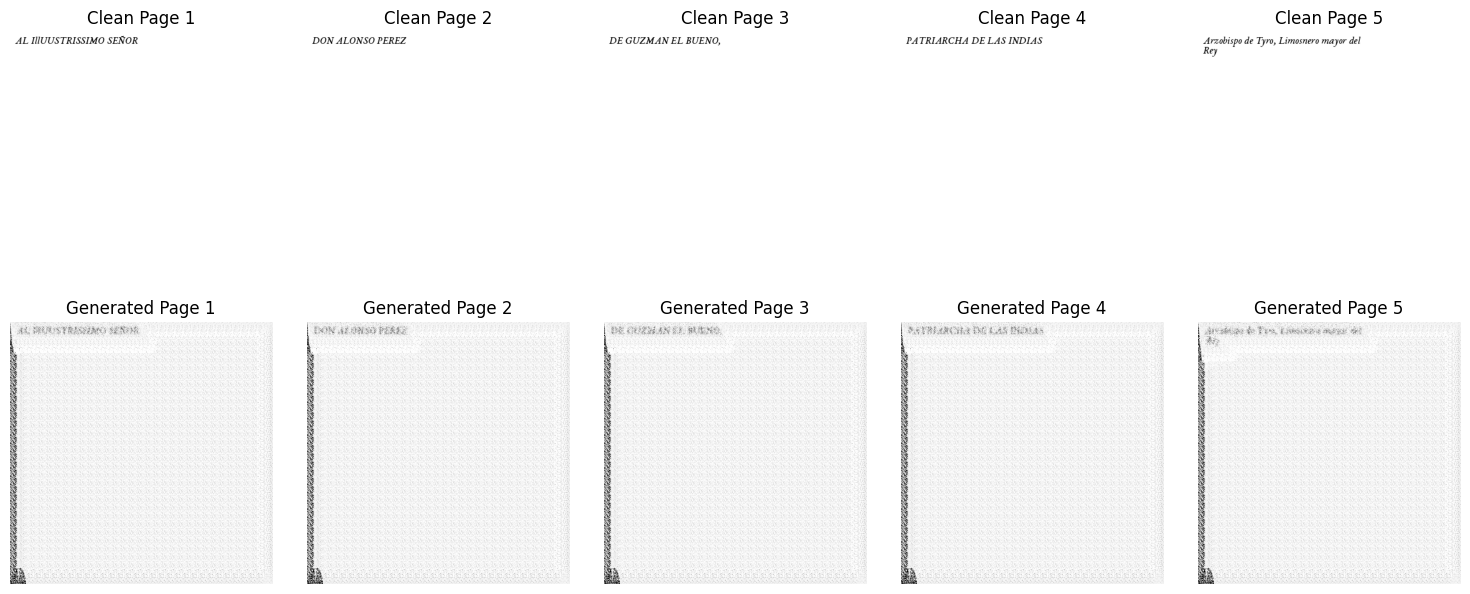

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    clean_img = cv2.imread(f"dataset/clean/page_{i+1}.png", 0)
    gen_img = cv2.imread(f"output/generated_page_{i+1}.png", 0)
    axs[0, i].imshow(clean_img, cmap="gray")
    axs[0, i].set_title(f"Clean Page {i+1}")
    axs[0, i].axis("off")
    axs[1, i].imshow(gen_img, cmap="gray")
    axs[1, i].set_title(f"Generated Page {i+1}")
    axs[1, i].axis("off")
plt.tight_layout()
plt.show()